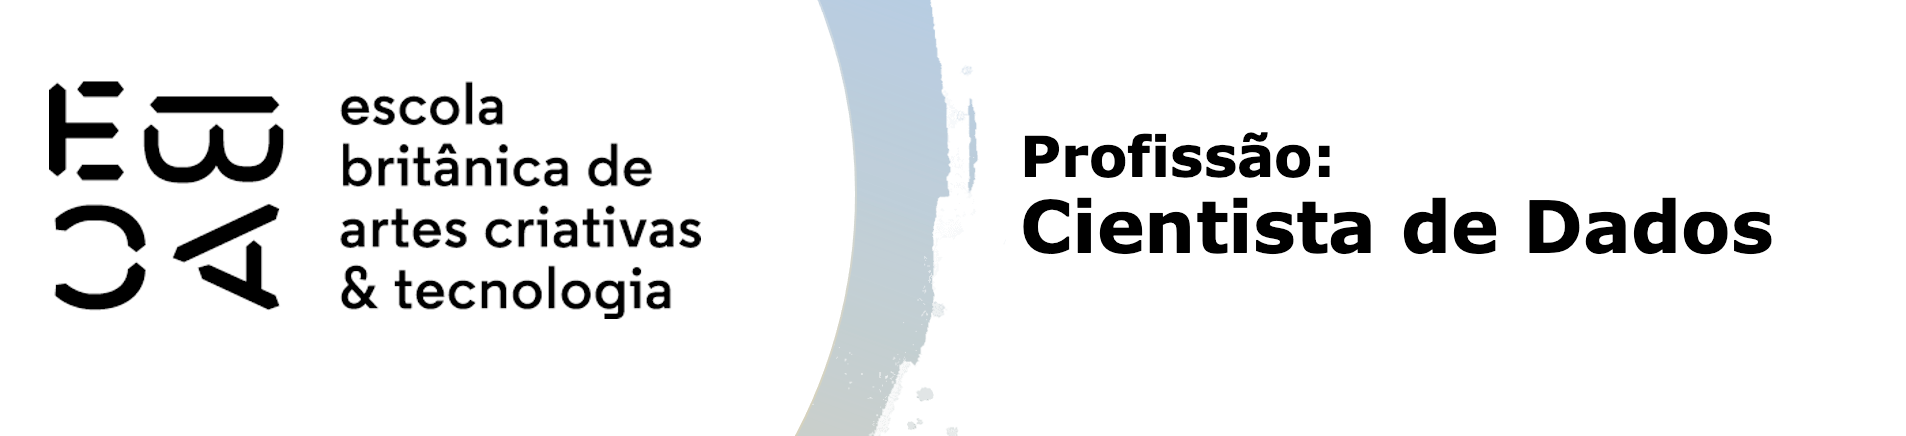

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [75]:
%%time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

CPU times: total: 0 ns
Wall time: 0 ns


In [76]:
df = pd.read_pickle('base_nfp.pkl')
df.head(3)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [77]:
df = df[(df['Data Registro'].dt.year == 2020) & (df['Data Registro'].dt.month == 1)]
# df['Data Registro'].unique()

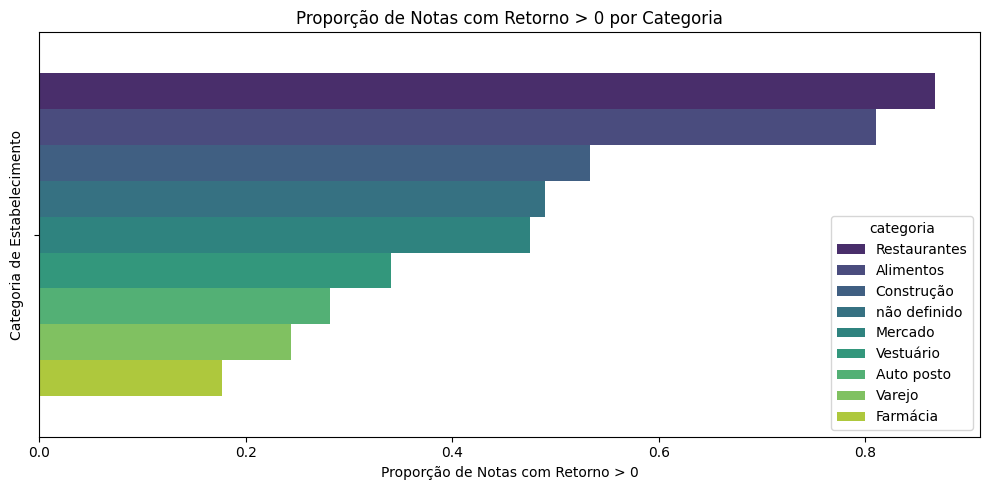

In [78]:
df['flag_retorno'] = (df['Retorno'] > 0).astype(int)

proporcao_retorno = df.groupby('categoria')['flag_retorno'].mean().reset_index()

proporcao_retorno = proporcao_retorno.sort_values(by='flag_retorno', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=proporcao_retorno, x='flag_retorno', hue='categoria', palette='viridis')
plt.xlabel('Proporção de Notas com Retorno > 0')
plt.ylabel('Categoria de Estabelecimento')
plt.title('Proporção de Notas com Retorno > 0 por Categoria')
plt.tight_layout()
plt.show()

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [79]:
df_cal = pd.crosstab(df.categoria, df.flag_retorno, margins=True, margins_name='total')

df_cal

flag_retorno,0,1,total
categoria,,,
Alimentos,52,223,275
Auto posto,28,11,39
Construção,299,342,641
Farmácia,288,62,350
Mercado,536,485,1021
Restaurantes,32,210,242
Varejo,93,30,123
Vestuário,64,33,97
não definido,339,326,665


In [80]:
df_cal['pct_nao_evento'] = df_cal[0]/df_cal.loc['total',0]
df_cal['pct_evento']     = df_cal[1]/df_cal.loc['total',1]
df_cal

flag_retorno,0,1,total,pct_nao_evento,pct_evento
categoria,,,,,
Alimentos,52,223,275,0.030040,0.129501
Auto posto,28,11,39,0.016176,0.006388
Construção,299,342,641,0.172733,0.198606
Farmácia,288,62,350,0.166378,0.036005
Mercado,536,485,1021,0.309648,0.281649
Restaurantes,32,210,242,0.018486,0.121951
Varejo,93,30,123,0.053726,0.017422
Vestuário,64,33,97,0.036973,0.019164
não definido,339,326,665,0.195841,0.189315


In [81]:
df_cal['WOE'] = np.log(df_cal['pct_evento']/df_cal['pct_nao_evento'])
df_cal

flag_retorno,0,1,total,pct_nao_evento,pct_evento,WOE
categoria,,,,,,
Alimentos,52,223,275,0.030040,0.129501,1.461141
Auto posto,28,11,39,0.016176,0.006388,-0.929096
Construção,299,342,641,0.172733,0.198606,0.139580
Farmácia,288,62,350,0.166378,0.036005,-1.530613
Mercado,536,485,1021,0.309648,0.281649,-0.094772
Restaurantes,32,210,242,0.018486,0.121951,1.886584
Varejo,93,30,123,0.053726,0.017422,-1.126189
Vestuário,64,33,97,0.036973,0.019164,-0.657163
não definido,339,326,665,0.195841,0.189315,-0.033890


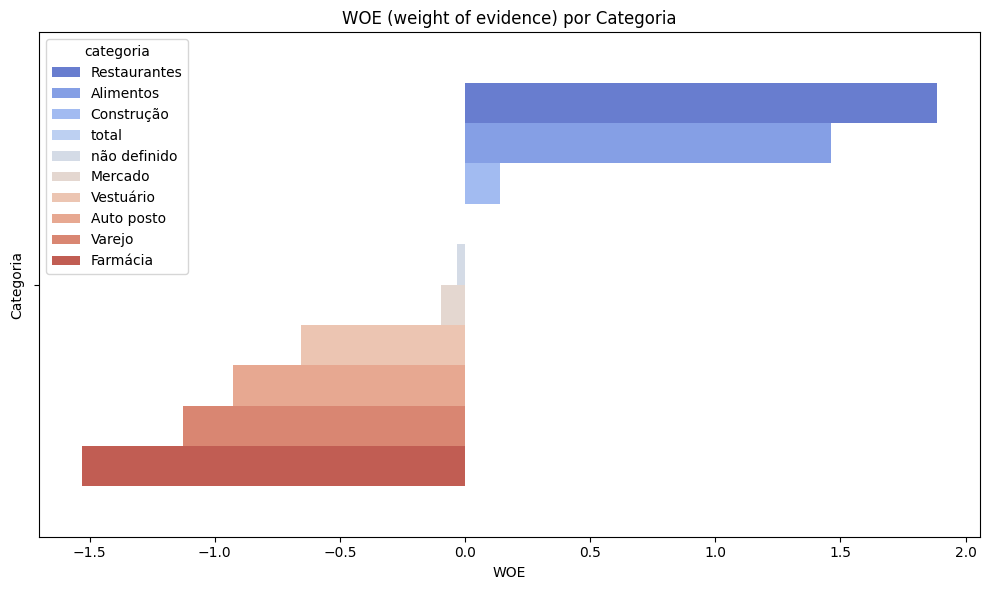

In [84]:
df_cal = df_cal.sort_values(by='WOE', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_cal, x='WOE', hue='categoria', palette='coolwarm')
plt.title('WOE (weight of evidence) por Categoria')
plt.xlabel('WOE')
plt.ylabel('Categoria')
plt.tight_layout()
plt.show()

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [83]:
df_cal['iv_parcial'] = (df_cal.pct_evento - df_cal.pct_nao_evento)*df_cal.WOE
print(df_cal.iv_parcial.sum())
df_cal

0.6082403449263944


flag_retorno,0,1,total,pct_nao_evento,pct_evento,WOE,iv_parcial
categoria,,,,,,,
Restaurantes,32,210,242,0.018486,0.121951,1.886584,0.195195
Alimentos,52,223,275,0.030040,0.129501,1.461141,0.145325
Construção,299,342,641,0.172733,0.198606,0.139580,0.003611
total,1731,1722,3453,1.000000,1.000000,0.000000,0.000000
não definido,339,326,665,0.195841,0.189315,-0.033890,0.000221
Mercado,536,485,1021,0.309648,0.281649,-0.094772,0.002653
Vestuário,64,33,97,0.036973,0.019164,-0.657163,0.011703
Auto posto,28,11,39,0.016176,0.006388,-0.929096,0.009094
Varejo,93,30,123,0.053726,0.017422,-1.126189,0.040886


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


Depois de calcular o WOE por categoria de estabelecimento, o IV mostra um valor de <font color='red'>0.61</font>. Segundo Siddiqi, este valor estaria na faixa _0,5 ou mais_, indicando "suspeito de tão alto". Logo, é questionável a predição que a amostra oferece para a análise utilizando WOE e IV.